In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pykan
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch

# Load your dataset
file_path = '/content/drive/MyDrive/repo2001_1.csv'
data = pd.read_csv(file_path)
columns = ['30yearUSTBill', 'usdinr', 'M3', 'FedRate', 'forwardpremium', 'wticrude', 'infl', 'repo']
data_values = data[columns].values

def create_dataset_rolling_window(data, window_size=5):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size].flatten())
        y.append(data[i+window_size][-1])  # 'repo' as target
    return np.array(X), np.array(y)

X, y = create_dataset_rolling_window(data_values, window_size=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 7.6 MB/s eta 0:00:00


In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the MLP model
mlp_model = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Predictions and accuracy for MLP
predicted_mlp_test = mlp_model.predict(X_test)
mlp_mse = mean_squared_error(y_test, predicted_mlp_test)
mlp_r2 = r2_score(y_test, predicted_mlp_test)
print(f'MLP Model - MSE: {mlp_mse}, R2: {mlp_r2}')

MLP Model - MSE: 0.6177119025118009, R2: 0.6415238375964598


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
from kan import KAN  # Import your KAN model definition

# Scale inputs
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale outputs
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Set up the KAN model
input_size = X_train_scaled.shape[1]
kan_model = KAN(width=[input_size, 10, 10, 1], grid=100, k=3, device='cpu')

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Set model to training mode
kan_model.train(True)

# Define optimizer and loss function
optimizer = torch.optim.Adam(kan_model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

# Training loop
for epoch in range(500):
    optimizer.zero_grad()
    predictions = kan_model(X_train_tensor)
    loss = loss_fn(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

# Set model to evaluation mode for testing
kan_model.train(False)

# Make predictions on the test set
with torch.no_grad():
    predicted_kan_test = kan_model(X_test_tensor).numpy()

# Inverse transform predictions and targets
predicted_kan_test = scaler_y.inverse_transform(predicted_kan_test)
y_test_original = scaler_y.inverse_transform(y_test_tensor.numpy())

# Calculate MSE and R²
kan_mse = mean_squared_error(y_test_original, predicted_kan_test)
kan_r2 = r2_score(y_test_original, predicted_kan_test)

# Output the metrics
print(f'KAN Model - MSE: {kan_mse}, R2: {kan_r2}')


checkpoint directory created: ./model
saving model version 0.0
KAN Model - MSE: 0.6178041100502014, R2: 0.6414703130722046


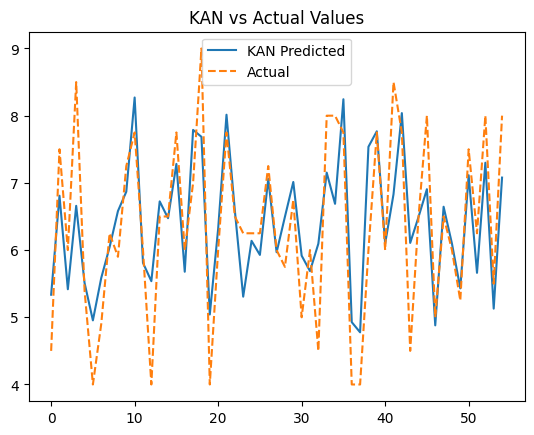

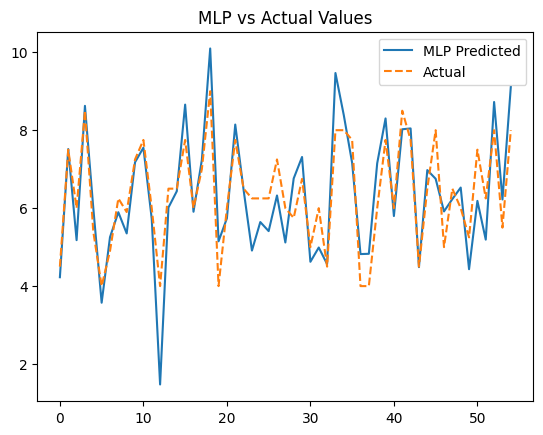

In [5]:
#Comparision b/w KAN, MLP prediction and actual values
import matplotlib.pyplot as plt

plt.plot(predicted_kan_test, label='KAN Predicted')
plt.plot(y_test, label='Actual', linestyle='--')
plt.title('KAN vs Actual Values')
plt.legend()
plt.show()

plt.plot(predicted_mlp_test, label='MLP Predicted')
plt.plot(y_test, label='Actual', linestyle='--')
plt.title('MLP vs Actual Values')
plt.legend()
plt.show()

checkpoint directory created: ./model
saving model version 0.0
KAN Model - MSE: 0.6845681536287012, R2: 0.568045181335407
MLP Model - MSE: 26.52887768571888, R2: -15.739423955624428


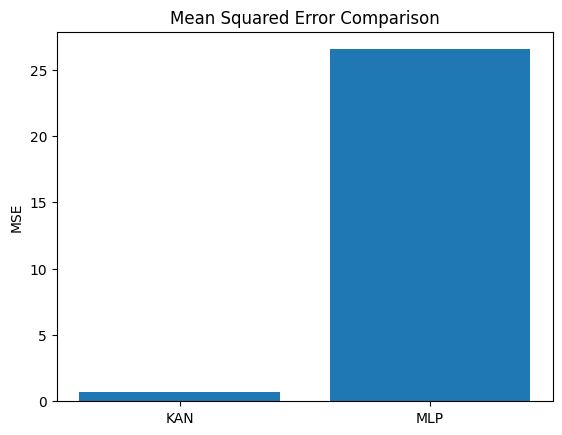

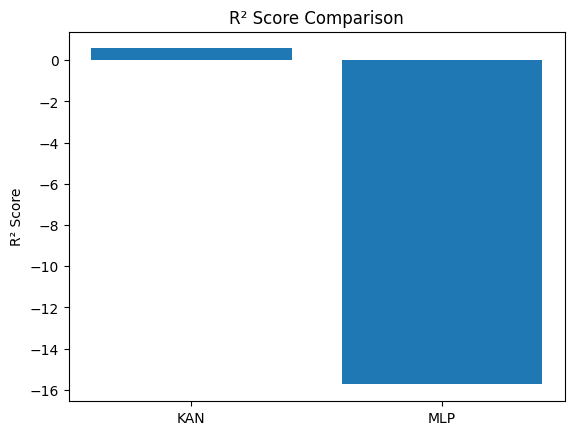

In [6]:
#Prediction model (predicting 6th column repo based on the other 5 columns)
#KAN and MLP
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from kan import KAN  # Import your KAN model definition

# Select five variables to use as inputs, and one as the target for prediction
input_columns = ['30yearUSTBill', 'usdinr', 'M3', 'FedRate', 'forwardpremium']
target_column = 'repo'  # Predicting the 'repo' column

# Prepare the features and target
X = data[input_columns].values  # Input features (5 variables)
y = data[target_column].values  # Target variable (6th variable)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension for target
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# KAN Model Initialization and Training
input_size = X_train_tensor.shape[1]  # Input size from the features
kan_model = KAN(width=[input_size, 10, 10, 1], grid=100, k=3, device='cpu')  # Initialize KAN

# Set model to training mode
kan_model.train(True)

# Define optimizer and loss function for KAN
optimizer = torch.optim.LBFGS(kan_model.parameters())
loss_fn = torch.nn.MSELoss()

# Training loop for KAN
for epoch in range(10):  # Adjust epochs as needed
    def closure():
        optimizer.zero_grad()
        predictions = kan_model(X_train_tensor)
        loss = loss_fn(predictions, y_train_tensor)
        loss.backward()
        return loss

    optimizer.step(closure)

# Set model to evaluation mode for testing
kan_model.train(False)

# Make predictions on the test set
with torch.no_grad():
    predicted_kan_test = kan_model(X_test_tensor).numpy()

# Calculate Mean Squared Error and R² score for KAN
kan_mse = mean_squared_error(y_test, predicted_kan_test)
kan_r2 = r2_score(y_test, predicted_kan_test)

print(f'KAN Model - MSE: {kan_mse}, R2: {kan_r2}')

# MLP Model Definition and Training
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(input_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Initialize the MLP model
mlp_model = MLP(input_size=5, hidden_sizes=[10, 10], output_size=1)

# Define optimizer and loss function for MLP
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
mlp_loss_fn = nn.MSELoss()

# Training loop for MLP
mlp_train_loss = []
mlp_test_loss = []

epochs = 10
for epoch in range(epochs):
    # Training phase
    mlp_model.train()
    mlp_optimizer.zero_grad()
    output = mlp_model(X_train_tensor)
    loss = mlp_loss_fn(output, y_train_tensor)
    loss.backward()
    mlp_optimizer.step()
    mlp_train_loss.append(loss.item())

    # Testing phase
    mlp_model.eval()
    with torch.no_grad():
        test_output = mlp_model(X_test_tensor)
        test_loss = mlp_loss_fn(test_output, y_test_tensor)
        mlp_test_loss.append(test_loss.item())

# Calculate MSE and R2 for MLP
with torch.no_grad():
    mlp_predictions = mlp_model(X_test_tensor).cpu().detach().numpy()

mlp_mse = mean_squared_error(y_test, mlp_predictions)
mlp_r2 = r2_score(y_test, mlp_predictions)

print(f"MLP Model - MSE: {mlp_mse}, R2: {mlp_r2}")

# Plot MSE of both models
plt.bar(['KAN', 'MLP'], [kan_mse, mlp_mse])
plt.title('Mean Squared Error Comparison')
plt.ylabel('MSE')
plt.show()

# Plot R^2 scores of both models
plt.bar(['KAN', 'MLP'], [kan_r2, mlp_r2])
plt.title('R² Score Comparison')
plt.ylabel('R² Score')
plt.show()



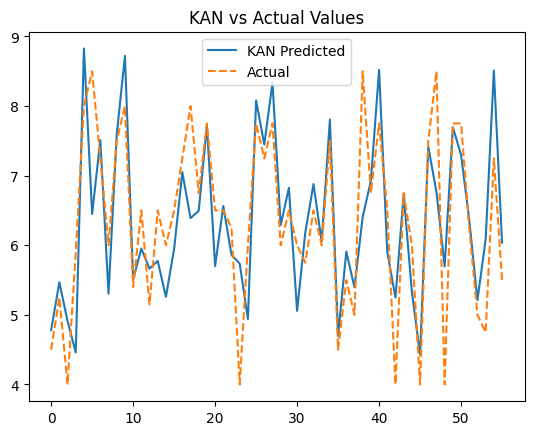

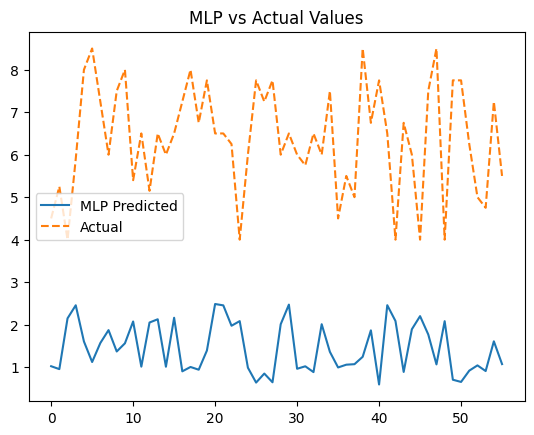

In [7]:
# Plot predictions vs actual values for KAN
plt.plot(predicted_kan_test, label='KAN Predicted')
plt.plot(y_test, label='Actual', linestyle='--')
plt.title('KAN vs Actual Values')
plt.legend()
plt.show()

# Plot predictions vs actual values for MLP
plt.plot(mlp_predictions, label='MLP Predicted')
plt.plot(y_test, label='Actual', linestyle='--')
plt.title('MLP vs Actual Values')
plt.legend()
plt.show()

In [ ]:
#Previous methods were Prediction models.
#The following methods are Time Series Forecasting models (predicting 6th entry in column based on previous 5 entries)

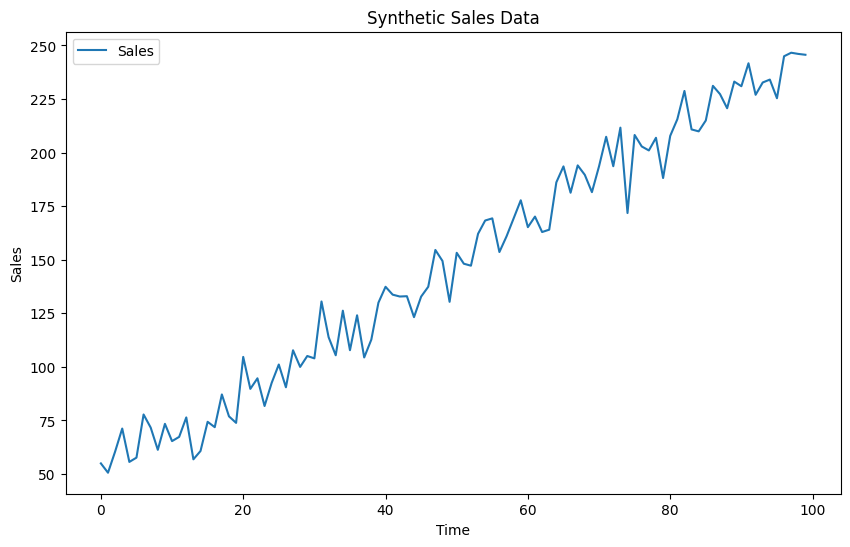

Mean Squared Error: 1088.13


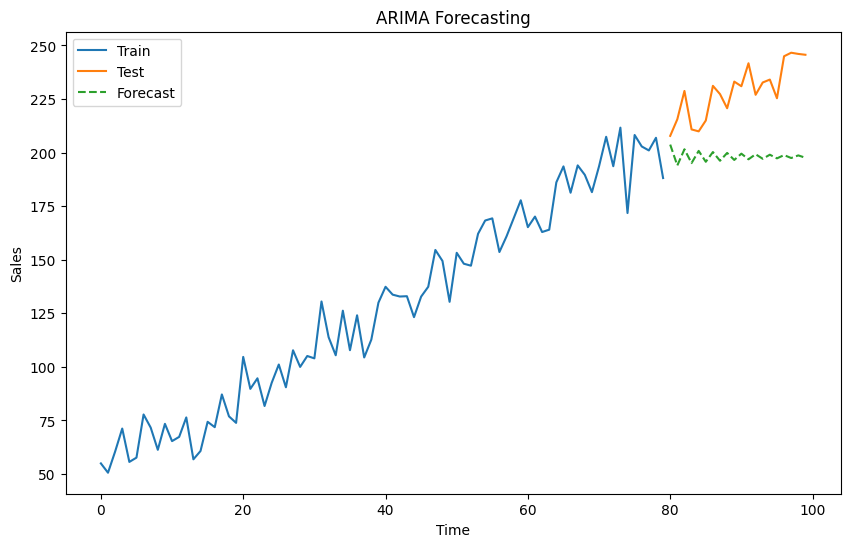

In [8]:
#Using the ARIMA forecasting model on a random time series dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Generate a synthetic time series dataset
np.random.seed(42)
n_periods = 100
time = np.arange(n_periods)
sales = 50 + 2 * time + np.random.normal(scale=10, size=n_periods)  # Trend + Noise

# Create a DataFrame
data = pd.DataFrame({'time': time, 'sales': sales})
data.set_index('time', inplace=True)

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['sales'], label='Sales')
plt.title("Synthetic Sales Data")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Split into training and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Build and train the ARIMA model
model = ARIMA(train, order=(2, 1, 2))  # (p, d, q)
fitted_model = model.fit()

# Forecast
forecast_steps = len(test)
forecast = fitted_model.forecast(steps=forecast_steps)

# Evaluate the model
mse = mean_squared_error(test['sales'], forecast)
print(f"Mean Squared Error: {mse:.2f}")

# Plot the forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['sales'], label='Train')
plt.plot(test.index, test['sales'], label='Test')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title("ARIMA Forecasting")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [10]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.5 MB/s eta 0:00:00


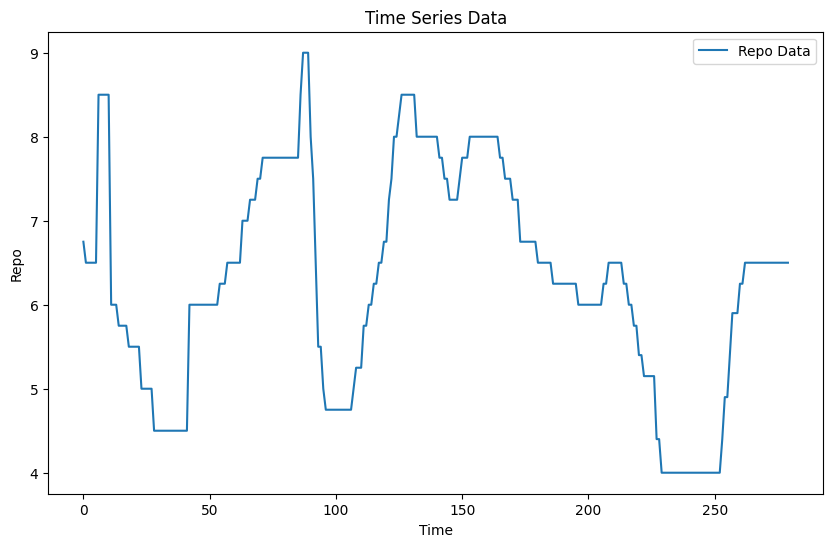

In [13]:
#Splitting the training and testing data of the repo column in our given dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
original_data = pd.read_csv(file_path)  # Renamed to original_data to avoid conflict

target_column = 'repo'  # This should already be defined
time_series = original_data[target_column]  # Access 'repo' from original dataset

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Repo Data')
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Repo')
plt.legend()
plt.show()

# Split the data into training and testing sets
train_size = int(len(time_series) * 0.72)
train, test = time_series[:train_size], time_series[train_size:]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 2.56


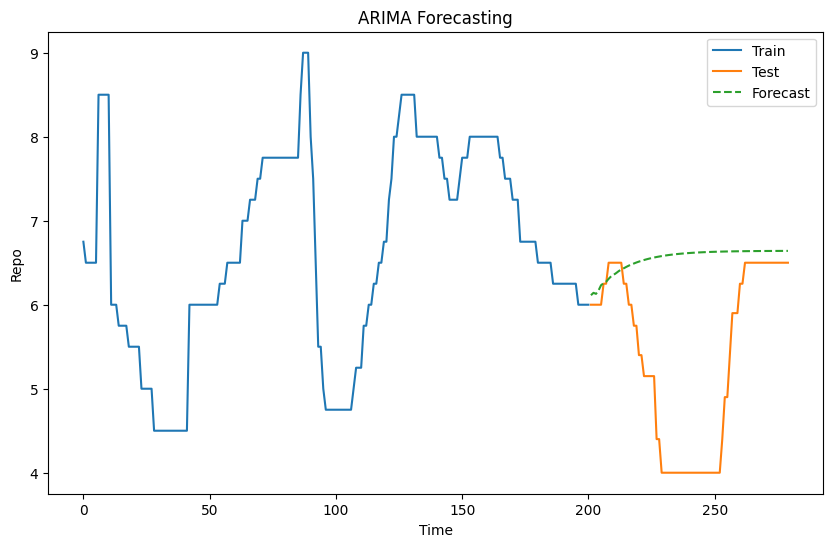

In [14]:
# ARIMA model forecasting

# In the ARIMA model, the parameters (p, d, q) in order=(p, d, q) define the structure of the model:
# p (autoregressive order):
# This parameter specifies the number of lag observations (previous time steps) included in the model.
# The model attempts to find a relationship between an observation and a specified number of its lagged values.
# Example: If p=3, the ARIMA model will use the past three observations to predict the next value.
# d (differencing order):
# This parameter represents the number of differences required to make the time series stationary.
# Differencing involves subtracting the previous observation from the current one, which helps remove trends or seasonality in the data.
# Example: If d=1, the model uses the first difference, meaning it models the change between consecutive observations.
# q (moving average order):
# This parameter specifies the size of the moving average window or the number of lagged forecast errors included in the model.
# The model corrects future predictions using the errors (residuals) from previous predictions.
# Example: If q=5, the model incorporates the forecast errors from the last five time steps into the current prediction.
model = ARIMA(train, order=(3, 1, 5))
fitted_model = model.fit()

# Forecast the test set
forecast = fitted_model.forecast(steps=len(test))

# Evaluate the model
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(train)), train, label='Train')
plt.plot(range(len(train), len(train) + len(test)), test, label='Test')
plt.plot(range(len(train), len(train) + len(test)), forecast, label='Forecast', linestyle='--')
plt.title('ARIMA Forecasting')
plt.xlabel('Time')
plt.ylabel('Repo')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=103.409, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=117.791, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=115.729, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=116.549, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=115.818, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=114.211, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=115.544, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=98.893, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=116.330, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=100.757, Time=0.63 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=100.832, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=99.689, Time=1.22 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=114.757, Time=2.02 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=100.654, Time=1.70 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=96.910,

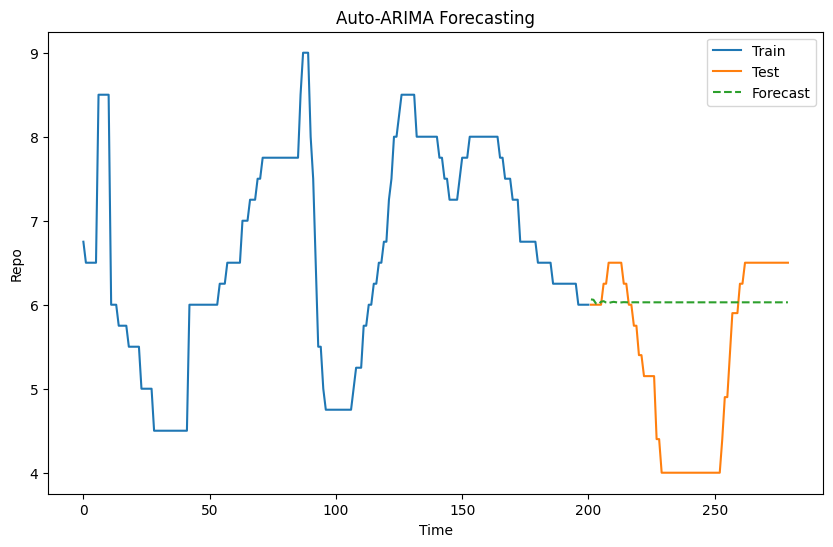

In [15]:
# Find optimal ARIMA parameters using auto_arima
auto_arima_model = auto_arima(
    train,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    stepwise=True
)
print(auto_arima_model.summary())

# Fit the model
fitted_model = auto_arima_model.fit(train)

# Forecast
forecast = auto_arima_model.predict(n_periods=len(test))

# Evaluate the model
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(train)), train, label='Train')
plt.plot(range(len(train), len(train) + len(test)), test, label='Test')
plt.plot(range(len(train), len(train) + len(test)), forecast, label='Forecast', linestyle='--')
plt.title('Auto-ARIMA Forecasting')
plt.xlabel('Time')
plt.ylabel('Repo')
plt.legend()
plt.show()

ETS - Mean Squared Error: 1.25


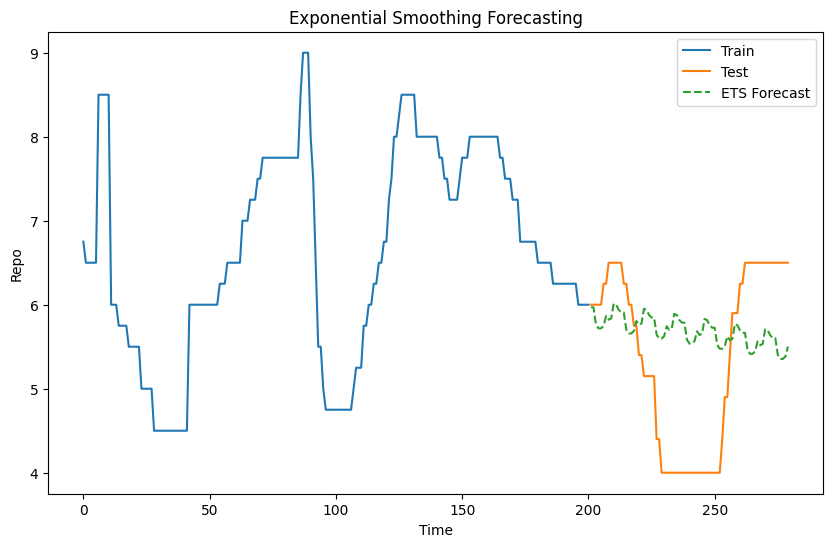

In [17]:
# Exponential Smoothing forecasting method
# ETS models are ideal for capturing the trend and seasonality in time series data.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# train_size = int(len(time_series) * 0.72)
# For ETS,
# 0.7 gives MSE of 1.56
# 0.71 gives MSE of 1.29
# 0.72 gives MSE of 1.25 (Least, then it increases)

# Fit the Exponential Smoothing model
ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
ets_fitted = ets_model.fit()

# Forecast the test set
ets_forecast = ets_fitted.forecast(len(test))

# Evaluate the model
mse = mean_squared_error(test, ets_forecast)
print(f"ETS - Mean Squared Error: {mse:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(train)), train, label='Train')
plt.plot(range(len(train), len(train) + len(test)), test, label='Test')
plt.plot(range(len(train), len(train) + len(test)), ets_forecast, label='ETS Forecast', linestyle='--')
plt.title('Exponential Smoothing Forecasting')
plt.xlabel('Time')
plt.ylabel('Repo')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.2893
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0778
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0610
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0258
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0296
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0282
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0211
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0226
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0177
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0165
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0163
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0103
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0119
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0105
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0101
Epoch 16/100
4/4 ━━

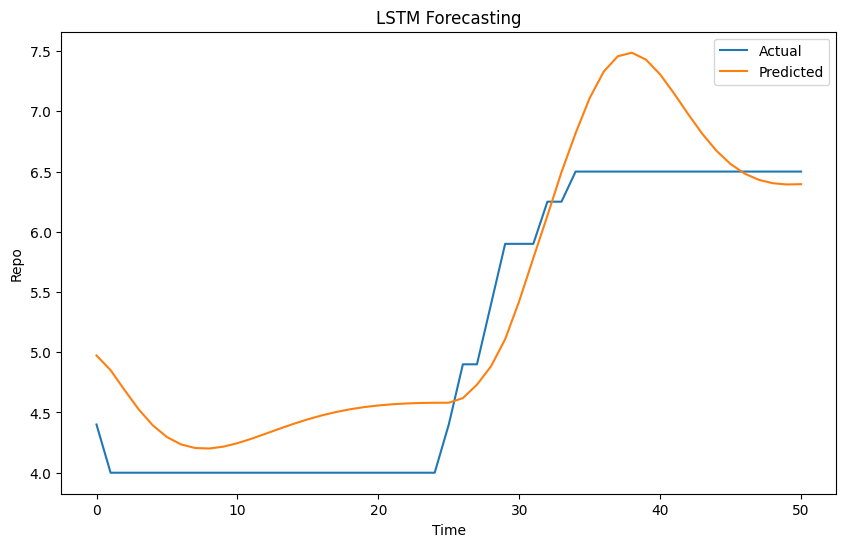

In [18]:
# LSTM method forecasting
# LSTMs are a type of recurrent neural network that can capture long-term dependencies in time series data. This method is more complex but often outperforms traditional methods.
# LSTM requires reshaping the data into a format suitable for training.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_scaled = scaler.fit_transform(time_series.values.reshape(-1, 1))

# Prepare the data for LSTM (lookback window)
# Prepare input-output pairs: x1, x2, x3, x4, x5 -> x6
def create_dataset(data, time_step=5):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(time_series_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.72)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"LSTM - Mean Squared Error: {mse:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Forecasting')
plt.xlabel('Time')
plt.ylabel('Repo')
plt.legend()
plt.show()


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - loss: 0.5024 - val_loss: 0.0415
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0896 - val_loss: 0.0086
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0162 - val_loss: 0.0148
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0274 - val_loss: 0.0111
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0187 - val_loss: 0.0080
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132 - val_loss: 0.0073
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - val_loss: 0.0068
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - val_loss: 0.0060
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0048
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 13/1

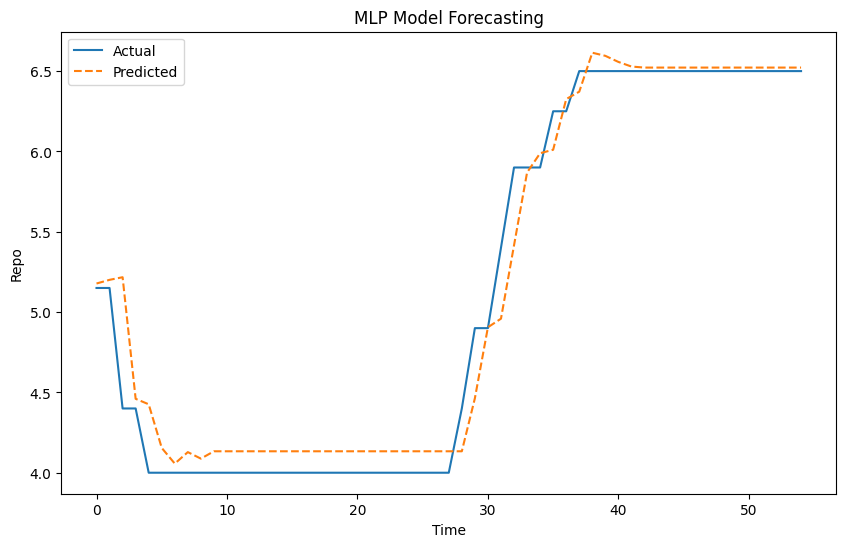

In [20]:
# MLP method forecasting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

# Prepare input-output pairs: x1, x2, x3, x4, x5 -> x6
def create_input_output_pairs(data, time_step=5):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step].values)  # Take 5 consecutive values as input
        y.append(data[i + time_step])  # The next value as the output (x6)
    return np.array(X), np.array(y)

X, y = create_input_output_pairs(time_series)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[1])).reshape(X.shape)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# The architecture consists of dense layers with ReLU activations, which is characteristic of an MLP.

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Hidden layer with ReLU
model.add(Dense(64, activation='relu'))  # Hidden layer with ReLU
model.add(Dense(1))  # Output layer for prediction

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"MLP Model - Mean Squared Error: {mse:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(predictions)), predictions, label='Predicted', linestyle='--')
plt.title('MLP Model Forecasting')
plt.xlabel('Time')
plt.ylabel('Repo')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 0.3239 - val_loss: 0.0978
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2992 - val_loss: 0.0923
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2776 - val_loss: 0.0837
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2239 - val_loss: 0.0690
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1420 - val_loss: 0.0451
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0651 - val_loss: 0.0249
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0642 - val_loss: 0.0262
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0457 - val_loss: 0.0324
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0415 - val_loss: 0.0291
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0417 - val_loss: 0.0228
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0397 - val_loss: 0.0212
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0342 - val_loss: 0.0198

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
True KAN Model with Splines - Mean Squared Error: 0.20


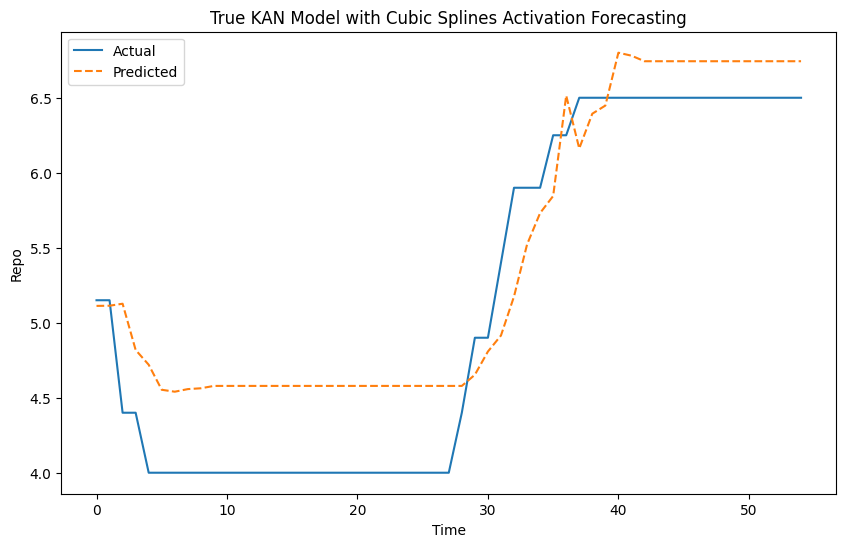

In [22]:
# KAN method forecasting

# Custom Activation:
# The cubic spline is implemented as a piecewise function with tf.where for conditional logic.
# The CubicSplineActivation class wraps this into a custom layer for TensorFlow/Keras.

# KAN Architecture:
# Two hidden layers are used with 128 and 64 neurons, respectively.
# Each hidden layer uses the cubic spline activation function.

# Training and Evaluation:
# The model is trained on 80% of the data and validated/tested on the remaining 20%.
# Predictions are inverse-transformed back to the original scale to calculate performance metrics like MSE and MAE.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Lambda
import tensorflow as tf


# Prepare input-output pairs: x1, x2, x3, x4, x5 -> x6
def create_input_output_pairs(data, time_step=5):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step].values)  # Take 5 consecutive values as input
        y.append(data[i + time_step])  # The next value as the output (x6)
    return np.array(X), np.array(y)

X, y = create_input_output_pairs(time_series)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[1])).reshape(X.shape)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Define a cubic spline activation function
def cubic_spline_activation(x):
    # Define a cubic spline as a piecewise function
    conditions = [
        x <= 0,
        (x > 0) & (x <= 1),
        x > 1
    ]
    functions = [
        lambda x: 0.5 * x**3,                # Region 1: Cubic spline below 0
        lambda x: x**2 - 0.5 * x**3,        # Region 2: Cubic spline between 0 and 1
        lambda x: 1.0                       # Region 3: Flat response above 1
    ]
    return tf.where(conditions[0], functions[0](x),
           tf.where(conditions[1], functions[1](x),
                    functions[2](x)))

# Wrap the cubic spline activation into a TensorFlow Lambda layer
class CubicSplineActivation(tf.keras.layers.Layer):
    def call(self, inputs):
        return cubic_spline_activation(inputs)

# Build the true KAN model with cubic spline activations
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1]))  # Hidden layer
model.add(CubicSplineActivation())                # Spline activation layer
model.add(Dense(64))                              # Hidden layer
model.add(CubicSplineActivation())                # Spline activation layer
model.add(Dense(1))                               # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"True KAN Model with Splines - Mean Squared Error: {mse:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(predictions)), predictions, label='Predicted', linestyle='--')
plt.title('True KAN Model with Cubic Splines Activation Forecasting')
plt.xlabel('Time')
plt.ylabel('Repo')
plt.legend()
plt.show()


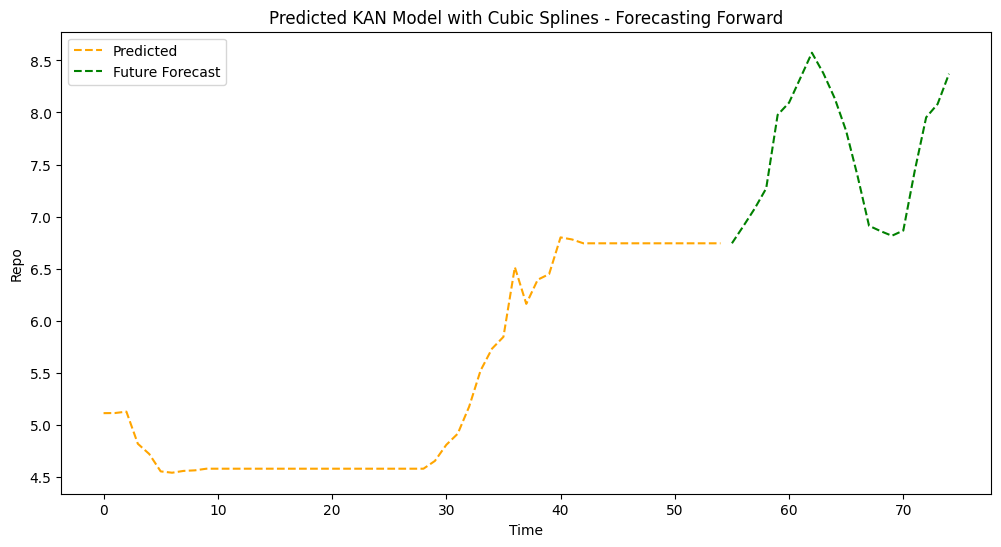

In [30]:
# Extend the forecasting forward
# Forecast future values using the trained model.

# Parameters:
# - model: Trained KAN model.
# - X_last: The last input sequence used for forecasting (shape: [1, time_steps]).
# - scaler: Scaler used for data normalization.
# - steps: Number of future time steps to forecast.

# Returns:
# - future_predictions: Array of forecasted values.

def forecast_future(model, X_last, scaler, steps=10):
    future_predictions = []
    current_input = X_last.copy()  # Start with the last available input sequence

    for _ in range(steps):
        # Predict the next value
        next_pred = model.predict(current_input, verbose=0)

        # Append the prediction to the results
        future_predictions.append(next_pred[0, 0])

        # Update the input sequence with the new prediction
        next_input = current_input[:, 1:]  # Shift the input sequence by one step
        next_input = np.concatenate((next_input, next_pred.reshape(1, 1)), axis=1)  # Add the prediction
        current_input = next_input

    # Inverse transform the predictions to the original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

    return future_predictions

# Select the last input sequence from the test set
X_last = X_test[-1:].reshape(1, X_test.shape[1])

# Forecast the next 20 time steps
future_steps = 20
future_predictions = forecast_future(model, X_last, scaler, steps=future_steps)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(predictions)), predictions, label='Predicted', linestyle='--', color='orange')
plt.plot(range(len(y_test), len(y_test) + future_steps), future_predictions, label='Future Forecast', linestyle='--', color='green')
plt.title('Predicted KAN Model with Cubic Splines - Forecasting Forward')
plt.xlabel('Time')
plt.ylabel('Repo')
plt.legend()
plt.show()